In [3]:
import h5py
import numpy as np
import os
import pandas as pd
import subprocess
import time

from os import listdir
from os.path import isfile, join

import bacco
import baccoemu

import matplotlib
from matplotlib import pyplot as plt

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

## Bacco setup

In [30]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=sigma8,
        #tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
    
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

In [31]:
ngrid = 256 #1024 #512 #256 #128 #256 #1400
#nmean=0.01 not used
BoxSize=100/hubble
print(BoxSize)

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}}) 
bacco.configuration.update({'pknbody' : {'interlacing' : True}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

149.0090895544628


## Load SAM data from hdf5 files

In [7]:
redshift = 0
dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

In [10]:
fns_dat = [join(dir_dat, f) for f in listdir(dir_dat) if isfile(join(dir_dat, f))]
#fn_dat = f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5'

## Plot CAMELS SMFs

In [32]:
log_mass_shift = 9
h = 0.6711 # from perez et al
print(h**3)
vol_Mpc = (100/h)**3 # 100 Mpc/h = 100/h Mpc
vol_hMpc = 100**3 # units Mpc/h!! to match bgs; diff than plotted in camels paper
print(vol_Mpc, vol_hMpc)

0.302246803431
3308554.428527777 1000000


In [33]:
edges = np.linspace(8, 12.5, 40)

bin_width = edges[1] - edges[0]                
bins_avg = edges[0:-1] + bin_width/2.           

In [55]:
smf_arr = []
for fn_dat in fns_dat[:2]:
    with h5py.File(fn_dat, 'r') as f:
        mstar_raw = np.array(f['mstar'])
        log_mstar = np.log10(mstar_raw) + log_mass_shift
        
        phi, edges = np.histogram(log_mstar, bins=edges)   
        smf = phi / vol_Mpc / bin_width
        smf_arr.append(smf)    

/tmp/ipykernel_287041/3069512445.py:5: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift


In [56]:
len(mstar_raw), np.sum(mstar_raw>0), np.min(mstar_raw[mstar_raw>0]), np.max(mstar_raw)

(151840, 151839, 23.1067, 1498030.0)

In [58]:
np.log10(np.min(mstar_raw[mstar_raw>0])) + log_mass_shift

10.36373792582852

(array([9.7014e+04, 3.9956e+04, 1.6490e+04, 6.5860e+03, 2.5530e+03,
        9.2300e+02, 3.2300e+02, 1.3400e+02, 2.2000e+01, 4.0000e+00]),
 array([1.43066995, 1.85449249, 2.27831504, 2.70213758, 3.12596013,
        3.54978267, 3.97360522, 4.39742777, 4.82125031, 5.24507286,
        5.6688954 ]),
 <BarContainer object of 10 artists>)

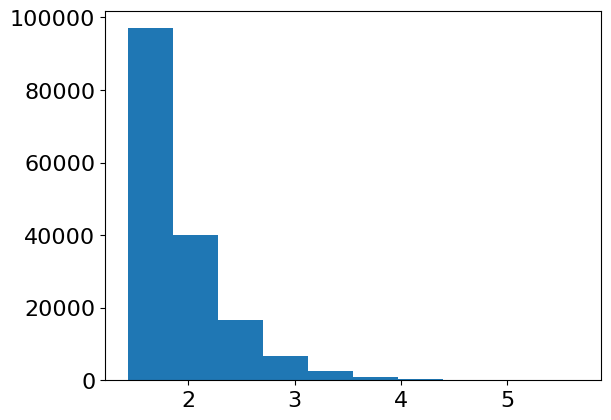

In [47]:
plt.hist(np.log10(mstar_raw[mstar_raw>0]))

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0., 33210., 27847., 22300.,
        17760., 13685., 10902.,  8277.,  6661.,  5242.,  4120.,  3199.,
         2512.,  1905.,  1452.,  1229.,   908.,   686.,   501.]),
 array([ 8.        ,  8.11538462,  8.23076923,  8.34615385,  8.46153846,
         8.57692308,  8.69230769,  8.80769231,  8.92307692,  9.03846154,
         9.15384615,  9.26923077,  9.38461538,  9.5       ,  9.61538462,
         9.73076923,  9.84615385,  9.96153846, 10.07692308, 10.19230769,
        10.30769231, 10.42307692, 10.53846154, 10.65384615, 10.76923077,
        10.88461538, 11.        , 11.11538462, 11.23076923, 11.34615385,
        11.46153846, 11.57692308, 11.69230769, 11.80769231, 11.92307692,
        12.03846154, 12.15384615, 12.26923077, 12.38461538, 12.5       ]),
 <BarContainer object of 39 artists>)

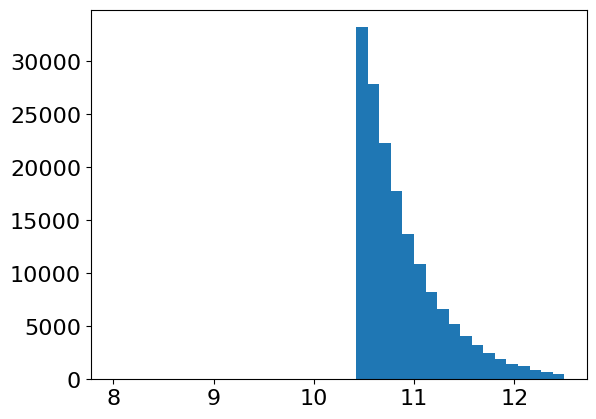

In [44]:
plt.hist(log_mstar, bins=edges)

Text(0, 0.5, '$\\Phi \\: [\\mathrm{dex}^{-1}\\, \\mathrm{Mpc}^{-3}]$')

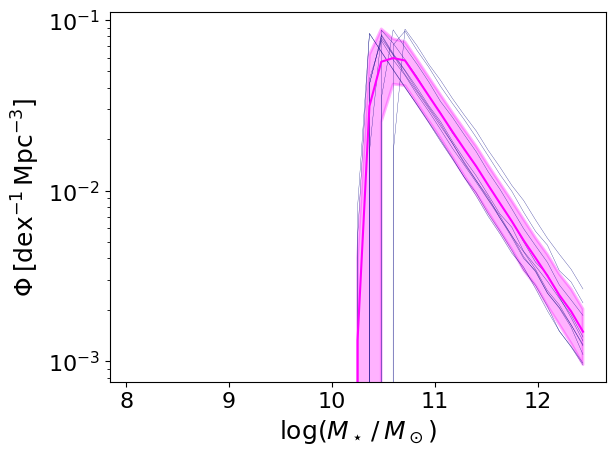

In [37]:
n_plot = 10
for i in range(n_plot):
    plt.plot(bins_avg, smf_arr[i], lw=0.2, color='navy')

smf_mean = np.mean(smf_arr, axis=0)
smf_std = np.std(smf_arr, axis=0)
plt.plot(bins_avg, smf_mean, color='magenta')
plt.fill_between(bins_avg, 
                 (smf_mean-smf_std), 
                 (smf_mean+smf_std),
                 color='magenta', alpha=0.3, lw=2,
                 label='pSMF all')
    
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')

## Set up bacco P(k) code

In [13]:
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':True,
                  'kmin':0.1,
                  'kmax':1.0,
                  'nbins':30,
                  'correct_grid':True,
                  'log_binning':False,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'normalise_grid': True,
                  'compute_power2d':False}

In [26]:
import logging
logger = logging.getLogger("bacco.power")
# only log really bad events
logger.setLevel(logging.ERROR)

In [28]:
pks = []
for fn_dat in fns_dat[:10]:
    with h5py.File(fn_dat, 'r') as f:
        x_arr, y_arr, z_arr = f['x_position'], f['y_position'], f['z_position']
        pos_arr = np.array([x_arr, y_arr, z_arr]).T
        pk = bacco.statistics.compute_powerspectrum(pos=pos_arr, **args_power)
        pks.append(pk)

e_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 153179 (grid1) 153179 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.051548 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.075366 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 178582 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 178582 (grid1) 178582 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.047522 sec
bacco.power 

Text(0, 0.5, '$P(k)$')

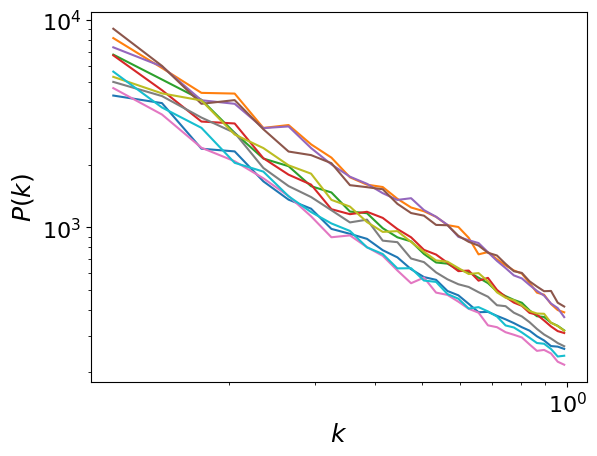

In [29]:
for i, fn_dat in enumerate(fns_dat[:10]):
    plt.plot(pks[i]['k'], pks[i]['pk'])
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')